In [55]:
import copick
import keras.src.losses
import pandas as pd
import zarr
from matplotlib import pyplot as plt
import os
import json
import numpy as np
from matplotlib import patches
from numba import njit, prange
from collections import defaultdict

from pandas.core.arrays.datetimes import objects_to_datetime64
from tqdm import tqdm
import tensorflow as tf
from keras import layers, Model
from typing import List, Dict
import gc
from copy import deepcopy
import random
import itertools
from tensorflow import keras
from tensorflow.keras import layers, Model
from collections import deque

In [56]:
def get_copick_root(split):
    """
    Loads the copick configuration based on the split.

    Args:
        split (str): 'train' or 'test'.

    Returns:
        copick_root: The loaded copick configuration.
    """
    config_path = '../../../copick_config.json' if split == 'train' else '../../../copick_config_test.json'
    if not os.path.exists(config_path):
        raise FileNotFoundError(f"Configuration file not found: {config_path}")
    copick_root = copick.from_file(config_path)
    return copick_root


In [57]:
def get_static_tomogram(run_name, split='train', tomo_type='denoised', zarr_group_idx=0):
    """
    Retrieves a static tomogram from the copick dataset.

    Args:
        run_name (str): Name of the run.
        split (str): 'train' or 'test'.
        tomo_type (str): Type of tomogram.
        zarr_group_idx (int): Index of the Zarr group.

    Returns:
        np.ndarray: The tomogram data as a NumPy array.
    """
    copick_root = get_copick_root(split)
    run = copick_root.get_run(run_name)
    voxel_spacing = run.get_voxel_spacing(10.000)
    tomogram = voxel_spacing.get_tomogram(tomo_type)
    zarr_store = tomogram.zarr()
    zarr_group = zarr.open(zarr_store, mode='r')
    try:
        tomogram_vals = zarr_group[str(zarr_group_idx)][:]  # Use string keys if necessary
    except KeyError:
        raise KeyError(f"Zarr group index {zarr_group_idx} not found in the store.")
    return tomogram_vals


In [58]:
# Load copick configurations
copick_root_train = get_copick_root('train')
copick_root_test = get_copick_root('test')

In [59]:
# Retrieve run names
training_runs = copick_root_train.runs
testing_runs = copick_root_test.runs

training_run_names = [run.name for run in training_runs]
testing_run_names = [run.name for run in testing_runs]
extra_training_run_names = list(set(training_run_names) - set(testing_run_names))

print(f'Training runs: {training_run_names}')
print(f'Testing runs: {testing_run_names}')
print(f'Extra training runs not in testing: {extra_training_run_names}')


Training runs: ['TS_5_4', 'TS_69_2', 'TS_6_4', 'TS_6_6', 'TS_73_6', 'TS_86_3', 'TS_99_9']
Testing runs: ['TS_5_4', 'TS_69_2', 'TS_6_4']
Extra training runs not in testing: ['TS_73_6', 'TS_99_9', 'TS_86_3', 'TS_6_6']


In [60]:
# Load tomograms
tomograms_train = []
tomograms_test = []

for training_run_name in training_run_names[:1]:
    try:
        tomo = get_static_tomogram(split='train', run_name=training_run_name)
        tomograms_train.append({'run': training_run_name, 'tomogram': tomo})
    except Exception as e:
        print(f"Error loading tomogram for run {training_run_name}: {e}")

for testing_run_name in testing_run_names:
    try:
        tomo = get_static_tomogram(split='test', run_name=testing_run_name)
        tomograms_test.append({'run': testing_run_name, 'tomogram': tomo})
    except Exception as e:
        print(f"Error loading tomogram for run {testing_run_name}: {e}")


print(f'Number of train tomograms: {len(tomograms_train)}')
print(f'Number of test tomograms: {len(tomograms_test)}')


Number of train tomograms: 1
Number of test tomograms: 3


In [61]:
# Verify the loaded tomograms
if tomograms_train:
    sample_tomo = tomograms_train[0]['tomogram']
    print(f"Type: {type(sample_tomo)}")
    print(f"Element Type: {type(sample_tomo[0])}")
    print(f"Shape: {sample_tomo.shape}")
else:
    print("No training tomograms loaded.")


Type: <class 'numpy.ndarray'>
Element Type: <class 'numpy.ndarray'>
Shape: (184, 630, 630)


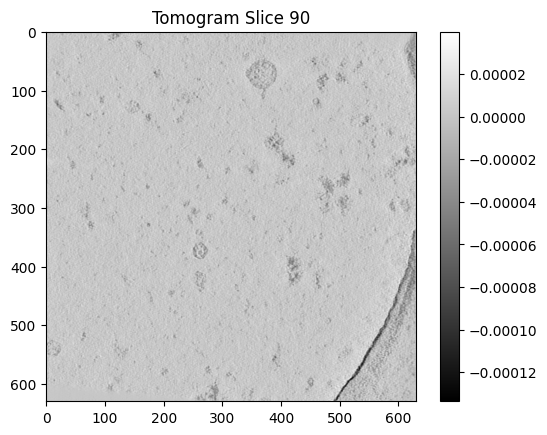

In [62]:
# Visualize a slice
if tomograms_train:
    slice_index = 90  # Adjust as needed
    if slice_index < tomograms_train[0]['tomogram'].shape[0]:
        plt.imshow(tomograms_train[0]['tomogram'][slice_index], cmap='gray')
        plt.title(f"Tomogram Slice {slice_index}")
        plt.colorbar()
        plt.show()
    else:
        print(
            f"Slice index {slice_index} out of range for tomogram with depth {tomograms_train[0]['tomogram'].shape[0]}")
else:
    print("No training tomograms to visualize.")


In [63]:
def get_label_locations(run_name, copick_root, voxel_spacing=10):
    """
    Extracts label locations from JSON files for a given run.

    Args:
        run_name (str): Name of the run.
        copick_root: Copick root object.
        voxel_spacing (float): Voxel spacing for normalization.

    Returns:
        dict: Dictionary with particle names as keys and arrays of locations as values.
    """
    picks_folder = os.path.join(copick_root.config.overlay_root, 'ExperimentRuns', run_name, 'Picks')
    if not os.path.exists(picks_folder):
        raise FileNotFoundError(f"Picks folder not found: {picks_folder}")

    picks = {}
    for json_file in os.listdir(picks_folder):
        if json_file.endswith('.json'):
            json_path = os.path.join(picks_folder, json_file)
            with open(json_path, 'r') as file:
                pick_data = json.load(file)
            particle_name = json_file[:-5]  # Remove '.json' extension
            picks[particle_name] = np.array([
                [
                    point['location']['x'] / voxel_spacing,
                    point['location']['y'] / voxel_spacing,
                    point['location']['z'] / voxel_spacing
                ]
                for point in pick_data.get('points', [])
            ])
    return picks

def get_particle_locations(run_name):
    # Create DataFrame with particle locations
    rows = []
    
    label_data = get_label_locations(run_name, copick_root_train)
    for particle, locations in label_data.items():
        matching_particles = [obj.radius for obj in copick_root_train.config.pickable_objects if obj.name == particle]
        if not matching_particles:
            print(f"No matching particle found for {particle} in run {run}")
            continue
        radius = matching_particles[0] / 10
        for location in locations:
            rows.append({
                'particle': particle,
                'x': location[0],
                'y': location[1],
                'z': location[2],
                'radius': radius
            })
    
    particle_locations_df = pd.DataFrame(rows)
    
    return particle_locations_df

for run in training_run_names:
    particle_locations = get_particle_locations(run)
    for tomo in tomograms_train:
        if tomo['run'] == run:
            tomo['particle_locations']=particle_locations

print(f"Total labeled particles in {tomograms_train[0]['run']}: {len(tomograms_train[0]['particle_locations'])}")
print(f'Sample of particle location in {tomograms_train[0]['run']}:')
print(tomograms_train[0]['particle_locations'].sample(5))

Total labeled particles in TS_5_4: 140
Sample of particle location in TS_5_4:
          particle         x         y        z  radius
132  thyroglobulin  291.7805  395.8293  73.0732    13.0
70    apo-ferritin  456.9735  124.9967  73.5033     6.0
135  thyroglobulin  217.5491  310.0549  45.2861    13.0
98    apo-ferritin  465.7210  513.0873  98.9265     6.0
65    apo-ferritin  567.4694  111.4354  56.5068     6.0


In [64]:
unique_particles=pd.DataFrame()
for tomo in tomograms_train:
    unique_particles = pd.concat([unique_particles,tomo['particle_locations'][['particle','radius']].drop_duplicates()],axis=0,ignore_index=True)
unique_particles=unique_particles.drop_duplicates()

particle_types = sorted(unique_particles['particle'].unique())

particle_sizes = {}
for i in unique_particles.to_dict(orient='records'):
    particle_sizes[i['particle']] = i['radius']

# Print the unique particle types and their radii
print("Unique Particle Types and Their Radii:")
print(unique_particles.sort_values(by='radius', ascending=False).reset_index(drop=True))

Unique Particle Types and Their Radii:
              particle  radius
0             ribosome    15.0
1  virus-like-particle    13.5
2        thyroglobulin    13.0
3   beta-galactosidase     9.0
4         beta-amylase     6.5
5         apo-ferritin     6.0


In [65]:
label_to_id={}

def compute_ground_truth_boxes(df,label_to_id):
    """
    Computes ground truth bounding boxes from particle center points and radii.

    Args:
        df (pd.DataFrame): DataFrame with columns ['run', 'particle', 'x', 'y', 'z', 'radius'].

    Returns:
        np.ndarray: Array of ground truth boxes with shape (N, 6), where each box is (x_min, y_min, z_min, x_max, y_max, z_max).
        np.ndarray: Array of corresponding particle labels (strings).
    """
    # Compute the min and max bounds for each box
    x_min = df['x'] - df['radius']
    x_max = df['x'] + df['radius']
    y_min = df['y'] - df['radius']
    y_max = df['y'] + df['radius']
    z_min = df['z'] - df['radius']
    z_max = df['z'] + df['radius']
    
    # Combine min and max bounds into a single array
    ground_truth_boxes = np.stack([x_min, y_min, z_min, x_max, y_max, z_max], axis=1)
    
    ground_truth_indices = list(range(len(ground_truth_boxes)))
   
    # Create a mapping of particle labels to integer IDs
    unique_labels = df['particle'].unique()
    for label in unique_labels:
        if label not in label_to_id:
            if len(label_to_id)==0:
                label_to_id[label]=0
            else:
                label_to_id[label]=max(label_to_id.values()) + 1
    
    # Encode particle labels as integers
    encoded_labels = df['particle'].map(label_to_id).values
    
    return ground_truth_indices, ground_truth_boxes, encoded_labels


for tomo in tomograms_train:
    tomo['ground_truth_indices'],tomo['ground_truth_boxes'],tomo['ground_truth_labels'] = compute_ground_truth_boxes(tomo['particle_locations'],label_to_id)
    print(f'Number of ground truth boxes in run {tomo['run']}: {len(tomo['ground_truth_boxes'])}')

id_to_label = {idx:label for label,idx in label_to_id.items()}

gt_sizes = tomograms_train[0]['ground_truth_boxes'][:,4]-tomograms_train[0]['ground_truth_boxes'][:,1]
unique_gt_sizes = np.unique(gt_sizes)
print('Unique ground truth box radii:')
print(np.unique([round(i,4)/2 for i in unique_gt_sizes]))
print('Unique ground truth box diameters:')
print(np.unique([round(i,4) for i in unique_gt_sizes]))

del gt_sizes
del unique_gt_sizes

Number of ground truth boxes in run TS_5_4: 140
Unique ground truth box radii:
[ 6.   6.5  9.  13.  13.5 15. ]
Unique ground truth box diameters:
[12. 13. 18. 26. 27. 30.]


In [66]:
for tomo in tomograms_train:
    # Prepare tomogram for model input
    tomo['tomogram_with_channel'] = np.expand_dims(tomo['tomogram'], axis=-1)  # Add channel dimension
    
print(f"Tomogram Shape: {tomograms_train[0]['tomogram'].shape}")
print(f'Tomogram With Channel Shape: {tomograms_train[0]['tomogram_with_channel'].shape}')

Tomogram Shape: (184, 630, 630)
Tomogram With Channel Shape: (184, 630, 630, 1)


In [67]:
def build_backbone(input_shape):
    inputs = keras.layers.Input(shape=input_shape)
    
    # Backbone
    x = layers.Conv3D(32,(3,3,3),activation='relu',padding='same')(inputs)
    x = layers.MaxPooling3D(pool_size=(2,2,2),padding='same')(x)
    x = layers.Conv3D(64,(3,3,3),activation='relu',padding='same')(x)
    x = layers.MaxPooling3D(pool_size=(2,2,2),padding='same')(x)
    
    model = keras.Model(inputs=inputs, outputs=x,name='backbone')

    return model

def calculate_cumulative_stride(backbone_model):
    """
    Calculates the cumulative stride of the backbone CNN by traversing its layers.
    
    Args:
        backbone_model (keras.Model): The backbone CNN model.
    
    Returns:
        tuple: Cumulative strides along (z, y, x).
    """
    stride_z, stride_y, stride_x = 1, 1, 1
    for layer in backbone_model.layers:
        if isinstance(layer, layers.MaxPooling3D):
            pool_size = layer.pool_size  # e.g., (2, 2, 2)
            strides = layer.strides      # e.g., (2, 2, 2)
            stride_z *= strides[0]
            stride_y *= strides[1]
            stride_x *= strides[2]
    return stride_z, stride_y, stride_x

backbone = build_backbone(tomograms_train[0]['tomogram_with_channel'].shape)
feature_map = backbone.output
print(f'Input Tomogram Shape: {tomograms_train[0]['tomogram_with_channel'].shape}')
print(f'Feature Map Shape: {feature_map.shape}')

# Calculate 
stride_z, stride_y, stride_x = calculate_cumulative_stride(backbone)
print(f"Cumulative Strides - Z: {stride_z}, Y: {stride_y}, X: {stride_x}")

scales=sorted(np.array(list(particle_sizes.values()))/stride_z*2)
print(f'Anchor box generation scales: {[str(i) for i in scales]}')

aspect_ratios = [(1, 1, 1)]
print(f'Anchor box generation aspect ratios: {aspect_ratios}')
boxes_per_anchors = len(scales) * len(aspect_ratios)

Input Tomogram Shape: (184, 630, 630, 1)
Feature Map Shape: (None, 46, 158, 158, 64)
Cumulative Strides - Z: 4, Y: 4, X: 4
Anchor box generation scales: ['3.0', '3.25', '4.5', '6.5', '6.75', '7.5']
Anchor box generation aspect ratios: [(1, 1, 1)]


In [68]:
def create_anchors(feature_map_shape, scales, aspect_ratios):
    """
    Generates and clips anchor boxes based on the feature map and anchor parameters.

    Args:
        feature_map_shape (tuple): Shape of the feature map (batch_size, D, H, W, C).
        voxel_spacing (float): Voxel spacing used in the tomogram.
        scales (list): List of scales.
        aspect_ratios (list of tuples): List of aspect ratios (w, h, d).

    Returns:
        np.ndarray: Array of clipped anchor boxes with shape (N, 6).
    """
    D, H, W = feature_map_shape[1], feature_map_shape[2], feature_map_shape[3]
    # Define centers based on voxel spacing and feature map stride
    centers_z = np.arange(D)
    centers_y = np.arange(H)
    centers_x = np.arange(W)
    anchor_boxes,anchor_centres = generate_anchor_boxes_vectorized(centers_z, centers_y, centers_x, scales, aspect_ratios)
    anchor_boxes = clip_boxes(anchor_boxes, feature_map_shape)
    return anchor_boxes,anchor_centres

def clip_boxes(anchor_boxes, input_shape):
    """
    Clips anchor boxes to lie within the input volume.

    Args:
        anchor_boxes (np.ndarray): Array of anchor boxes with shape (N, 6).
        input_shape (tuple): Shape of the input volume (D, H, W, C).

    Returns:
        np.ndarray: Clipped anchor boxes.
    """
    D_max, H_max, W_max = input_shape[1], input_shape[2], input_shape[3]
    # Clipping
    anchor_boxes[:, 0] = np.clip(anchor_boxes[:, 0], 0, W_max - 1)  # x_min
    anchor_boxes[:, 1] = np.clip(anchor_boxes[:, 1], 0, H_max - 1)  # y_min
    anchor_boxes[:, 2] = np.clip(anchor_boxes[:, 2], 0, D_max - 1)  # z_min
    anchor_boxes[:, 3] = np.clip(anchor_boxes[:, 3], 0, W_max - 1)  # x_max
    anchor_boxes[:, 4] = np.clip(anchor_boxes[:, 4], 0, H_max - 1)  # y_max
    anchor_boxes[:, 5] = np.clip(anchor_boxes[:, 5], 0, D_max - 1)  # z_max
    return anchor_boxes

def generate_anchor_boxes_vectorized(centers_z, centers_y, centers_x, scales, aspect_ratios, stride=4):
    """
    Efficiently generates anchor boxes using numpy broadcasting with correct shape alignment.
    
    Args:
        centers_z (np.ndarray): Array of center z-coordinates, shape (Nz,)
        centers_y (np.ndarray): Array of center y-coordinates, shape (Ny,)
        centers_x (np.ndarray): Array of center x-coordinates, shape (Nx,)
        scales (list): List of scales, length S
        aspect_ratios (list of tuples): List of aspect ratios (w_ratio, h_ratio, d_ratio), length R
        stride (int): Stride factor between input and feature map
    
    Returns:
        np.ndarray: Array of anchor boxes with shape (Nz * Ny * Nx * S * R, 6), 
                    where each box is (x_min, y_min, z_min, x_max, y_max, z_max)
    """
    # Convert scales and aspect_ratios to NumPy arrays
    scales = np.array(scales)  # Shape: (S,)
    aspect_ratios = np.array(aspect_ratios)  # Shape: (R, 3)
    
    num_scales = scales.shape[0]
    num_ratios = aspect_ratios.shape[0]
    num_sizes = num_scales * num_ratios
    
    # Compute all (w, h, d) combinations
    # Repeat each scale for each aspect ratio
    scales_repeated = np.repeat(scales, num_ratios)  # Shape: (S*R,)
    aspect_ratios_tiled = np.tile(aspect_ratios, (num_scales, 1))  # Shape: (S*R, 3)
    sizes = scales_repeated[:, np.newaxis] * aspect_ratios_tiled  # Shape: (S*R, 3)
    
    # Generate all combinations of center coordinates
    # Using meshgrid with 'ij' indexing to match the nested loop order: z, y, x
    zz, yy, xx = np.meshgrid(centers_z, centers_y, centers_x, indexing='ij')  # Each of shape (Nz, Ny, Nx)
    centers = np.stack([xx, yy, zz], axis=-1).reshape(-1, 3)  # Shape: (Nz*Ny*Nx, 3)
    
    # Scale centers back to input space
    # centers = centers * stride  # Assuming each feature map voxel corresponds to 'stride' in input#
    
    # Number of centers and sizes
    N = centers.shape[0]  # Nz * Ny * Nx
    M = sizes.shape[0]    # S * R
    
    # Expand dimensions to enable broadcasting
    # centers_expanded: (N, 1, 3)
    # sizes_expanded: (1, M, 3)
    centers_expanded = centers[:, np.newaxis, :]  # Shape: (N, 1, 3)
    sizes_expanded = sizes[np.newaxis, :, :]      # Shape: (1, M, 3)
    
    # Compute min and max coordinates
    mins = centers_expanded - sizes_expanded / 2.0  # Shape: (N, M, 3)
    maxs = centers_expanded + sizes_expanded / 2.0  # Shape: (N, M, 3)
    
    # Stack to get (x_min, y_min, z_min, x_max, y_max, z_max)
    anchor_boxes = np.concatenate([mins, maxs], axis=-1).reshape(-1, 6)  # Shape: (N*M, 6)
    
    # Duplicate centers for each anchor box type
    anchor_centres = np.repeat(centers, M, axis=0)  # Shape: (N*M, 3)
    
    return anchor_boxes, anchor_centres

print('Generating Anchor boxes for each tomogram...')
for tomo in tqdm(tomograms_train):
    # Generate anchor boxes based on the feature map
    tomo['anchor_boxes'], tomo['anchor_centres']= create_anchors(feature_map.shape, scales, aspect_ratios)
    
print(f"Generated {tomograms_train[-1]['anchor_boxes'].shape[0]} anchor boxes.\n")
print('Unique anchor box diameters (feature map space):')
print(np.unique(tomograms_train[-1]['anchor_boxes'][:,4]-tomograms_train[-1]['anchor_boxes'][:,1]))
print('Unique anchor box diameters (original image space):')
print(np.unique(tomograms_train[-1]['anchor_boxes'][:,4]-tomograms_train[-1]['anchor_boxes'][:,1])*stride_z)
print('\n')

print('Anchor boxes shape')
print(tomograms_train[-1]['anchor_boxes'].shape)
print('Anchor centres shape')
print(tomograms_train[-1]['anchor_centres'].shape)

Generating Anchor boxes for each tomogram...


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

Generated 6890064 anchor boxes.

Unique anchor box diameters (feature map space):
[1.5   1.625 2.25  2.5   2.625 3.    3.25  3.375 3.75  4.25  4.375 4.5
 4.75  5.25  5.375 5.75  6.25  6.375 6.5   6.75  7.5  ]
Unique anchor box diameters (original image space):
[ 6.   6.5  9.  10.  10.5 12.  13.  13.5 15.  17.  17.5 18.  19.  21.
 21.5 23.  25.  25.5 26.  27.  30. ]


Anchor boxes shape
(6890064, 6)
Anchor centres shape
(6890064, 3)


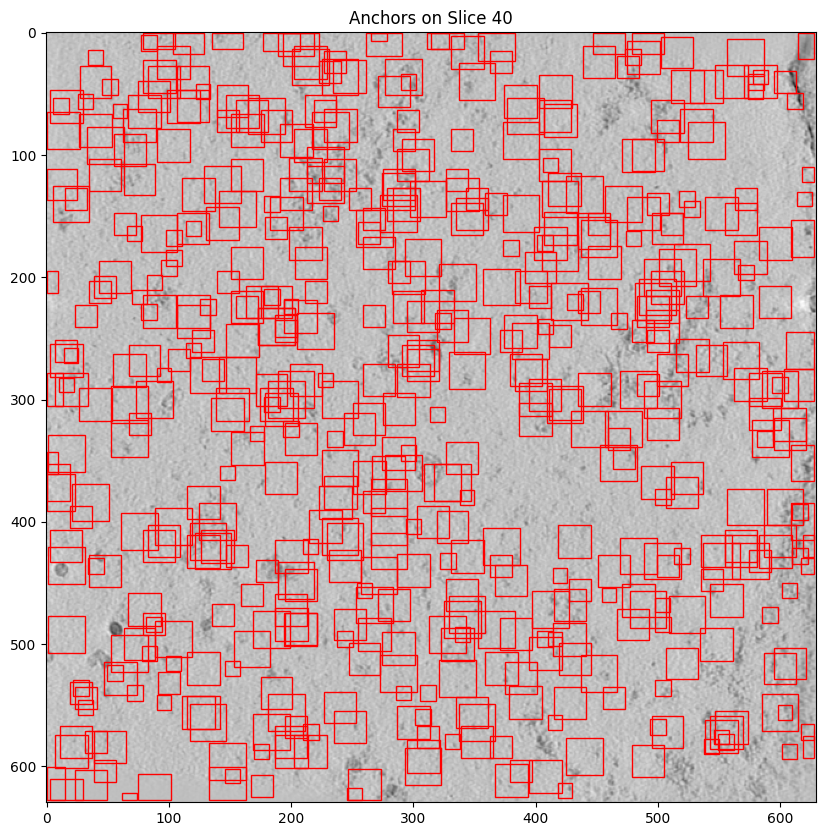

In [69]:
def visualize_anchors(tomogram, anchor_boxes, slice_index,strides, max_anchors=100):
    """
    Visualizes a subset of anchor boxes on a specific slice of the tomogram.

    Args:
        tomogram (np.ndarray): 3D tomogram data.
        anchors (np.ndarray): Array of anchor boxes with shape (N, 6).
        slice_index (int): Index of the slice to visualize.
        max_anchors (int): Maximum number of anchors to visualize.
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(tomogram[slice_index], cmap='gray')
    ax = plt.gca()
    count = 0
    
    num_boxes = anchor_boxes.shape[0]
    indices = np.random.choice(num_boxes, size=max_anchors, replace=False)
    random_anchors=anchor_boxes[indices]
    
    for anchor in random_anchors:
        
        # Convert anchor box to image space
        x_min = anchor[0] * strides[0]
        y_min = anchor[1] * strides[1]
        z_min = anchor[2] * strides[2]
        x_max = anchor[3] * strides[0]
        y_max = anchor[4] * strides[1]
        z_max = anchor[5] * strides[2]
        
        if z_min <= slice_index < z_max:
            rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
    plt.title(f"Anchors on Slice {slice_index}")
    plt.show() 
    
# Visualize a subset of anchors on a specific slice
slice_index = 40
strides=stride_z,stride_y,stride_x

visualize_anchors(tomograms_train[0]['tomogram'], tomograms_train[0]['anchor_boxes'], slice_index, strides, max_anchors=5000)

In [70]:
@njit
def floor_div(a, b):
    return np.floor(a / b).astype(np.int32)

def get_grid_indices(boxes, grid_min, grid_cell_size, grid_size):
    """
    Compute the grid cell indices (min and max) for each box.

    Args:
        boxes (np.ndarray): Array of boxes, shape (N, 6)
        grid_min (np.ndarray): Minimum coordinates of the grid, shape (3,)
        grid_cell_size (tuple): Size of each grid cell along (x, y, z)
        grid_size (tuple): Number of grid cells along (x, y, z)

    Returns:
        tuple: min_indices (N,3), max_indices (N,3)
    """
    min_indices = floor_div(boxes[:, :3] - grid_min, np.array(grid_cell_size))
    max_indices = floor_div(boxes[:, 3:6] - grid_min, np.array(grid_cell_size))
    
    # Clamp indices to be within [0, grid_size - 1]
    min_indices = np.maximum(min_indices, 0)
    max_indices = np.minimum(max_indices, np.array(grid_size) - 1)
    
    return min_indices, max_indices

def assign_gt_to_grid(ground_truth_boxes_fm, grid_min, grid_cell_size, grid_size):
    """
    Assign GT boxes to grid cells.

    Args:
        ground_truth_boxes_fm (np.ndarray): GT boxes in feature map space, shape (M, 6)
        grid_min (np.ndarray): Minimum coordinates of the grid, shape (3,)
        grid_cell_size (tuple): Size of each grid cell along (x, y, z)
        grid_size (tuple): Number of grid cells along (x, y, z)

    Returns:
        dict: Mapping from grid cell ID to list of GT box indices
    """
    M = ground_truth_boxes_fm.shape[0]
    gt_min_idx, gt_max_idx = get_grid_indices(ground_truth_boxes_fm, grid_min, grid_cell_size, grid_size)  # (M,3), (M,3)
    
    grid_dict = defaultdict(list)
    
    for gt_idx in range(M):
        x_min, y_min, z_min = gt_min_idx[gt_idx]
        x_max, y_max, z_max = gt_max_idx[gt_idx]
        
        for x in range(x_min, x_max + 1):
            for y in range(y_min, y_max + 1):
                for z in range(z_min, z_max + 1):
                    grid_id = x * grid_size[1] * grid_size[2] + y * grid_size[2] + z
                    grid_dict[grid_id].append(gt_idx)
    
    return grid_dict

def retrieve_relevant_gt(anchor_boxes, grid_min, grid_cell_size, grid_size, grid_dict, batch_size=10000):
    """
    Retrieve relevant GT boxes for each anchor based on grid cell overlap.

    Args:
        anchor_boxes (np.ndarray): Anchor boxes in feature map space, shape (N, 6)
        grid_min (np.ndarray): Minimum coordinates of the grid, shape (3,)
        grid_cell_size (tuple): Size of each grid cell along (x, y, z)
        grid_size (tuple): Number of grid cells along (x, y, z)
        grid_dict (dict): Mapping from grid cell ID to list of GT box indices
        batch_size (int): Number of anchors to process in each batch

    Returns:
        list of lists: Each sublist contains GT box indices relevant to the anchor
    """
    N = anchor_boxes.shape[0]
    print('Getting grid index for each anchor box')
    anchor_min_idx, anchor_max_idx = get_grid_indices(anchor_boxes, grid_min, grid_cell_size, grid_size)  # (N,3), (N,3)
    
    relevant_gt_per_anchor = [[] for _ in range(N)]
    
    print('Finding relevant ground truth boxes for each anchor')
    for start in tqdm(range(0, N, batch_size)):
        end = min(start + batch_size, N)
        batch_min = anchor_min_idx[start:end]  # (B,3)
        batch_max = anchor_max_idx[start:end]  # (B,3)
        
        for i in range(end - start):
            anchor_idx = start + i
            x_min, y_min, z_min = batch_min[i]
            x_max, y_max, z_max = batch_max[i]
            
            grid_ids = []
            for x in range(x_min, x_max + 1):
                for y in range(y_min, y_max + 1):
                    for z in range(z_min, z_max + 1):
                        grid_id = x * grid_size[1] * grid_size[2] + y * grid_size[2] + z
                        grid_ids.append(grid_id)
            
            gt_indices = []
            for grid_id in grid_ids:
                if grid_id in grid_dict:
                    gt_indices.extend(grid_dict[grid_id])
            
            # Remove duplicates
            gt_indices = list(set(gt_indices))
            relevant_gt_per_anchor[anchor_idx] = gt_indices
    
    return relevant_gt_per_anchor

def compute_iou_3d(boxes1, boxes2):
    """
    Computes IoU between two sets of 3D boxes using float32 for efficiency.

    Args:
        boxes1 (np.ndarray): Shape (N, 6) - [x_min, y_min, z_min, x_max, y_max, z_max].
        boxes2 (np.ndarray): Shape (M, 6) - [x_min, y_min, z_min, x_max, y_max, z_max].

    Returns:
        np.ndarray: IoU array of shape (N,)
    """
    # Compute intersection coordinates
    x_min = np.maximum(boxes1[:, 0], boxes2[:, 0])
    y_min = np.maximum(boxes1[:, 1], boxes2[:, 1])
    z_min = np.maximum(boxes1[:, 2], boxes2[:, 2])
    x_max = np.minimum(boxes1[:, 3], boxes2[:, 3])
    y_max = np.minimum(boxes1[:, 4], boxes2[:, 4])
    z_max = np.minimum(boxes1[:, 5], boxes2[:, 5])

    # Compute intersection dimensions
    inter_w = np.maximum(0, x_max - x_min)
    inter_h = np.maximum(0, y_max - y_min)
    inter_d = np.maximum(0, z_max - z_min)
    intersection = inter_w * inter_h * inter_d  # (N,)

    # Compute volumes
    volume1 = (boxes1[:, 3] - boxes1[:, 0]) * \
              (boxes1[:, 4] - boxes1[:, 1]) * \
              (boxes1[:, 5] - boxes1[:, 2])  # (N,)
    volume2 = (boxes2[:, 3] - boxes2[:, 0]) * \
              (boxes2[:, 4] - boxes2[:, 1]) * \
              (boxes2[:, 5] - boxes2[:, 2])  # (M,)

    # Compute union volume
    union = volume1 + volume2 - intersection  # (N,)

    # Compute IoU
    iou = intersection / np.maximum(union, 1e-6)  # Avoid division by zero

    return iou.astype(np.float32)  # Ensure float32

@njit(parallel=True)
def compute_deltas_batch_numba(anchor_boxes, gt_boxes, stride_array, deltas):
    """
    Numba-accelerated computation of deltas for a batch of anchors and GT boxes.

    Args:
        anchor_boxes (np.ndarray): Anchor boxes in feature map space, shape (K, 6).
        gt_boxes (np.ndarray): Ground truth boxes in image space, shape (K, 6).
                    stride_array (np.ndarray): Stride factors, shape (6,)
        deltas (np.ndarray): Output array for deltas, shape (K, 6).
    """
    K = anchor_boxes.shape[0]
    for i in prange(K):
        # Convert anchor box to image space
        x_min_a = anchor_boxes[i, 0] * stride_array[0]
        y_min_a = anchor_boxes[i, 1] * stride_array[1]
        z_min_a = anchor_boxes[i, 2] * stride_array[2]
        x_max_a = anchor_boxes[i, 3] * stride_array[3]
        y_max_a = anchor_boxes[i, 4] * stride_array[4]
        z_max_a = anchor_boxes[i, 5] * stride_array[5]
        
        # Compute centers and sizes
        x_a = (x_min_a + x_max_a) / 2.0
        y_a = (y_min_a + y_max_a) / 2.0
        z_a = (z_min_a + z_max_a) / 2.0
        w_a = x_max_a - x_min_a
        h_a = y_max_a - y_min_a
        d_a = z_max_a - z_min_a
        
        # GT box in image space
        x_min_g = gt_boxes[i, 0] * stride_array[0]
        y_min_g = gt_boxes[i, 1] * stride_array[1]
        z_min_g = gt_boxes[i, 2] * stride_array[2]
        x_max_g = gt_boxes[i, 3] * stride_array[3]
        y_max_g = gt_boxes[i, 4] * stride_array[4]
        z_max_g = gt_boxes[i, 5] * stride_array[5]
        
        x_g = (x_min_g + x_max_g) / 2.0
        y_g = (y_min_g + y_max_g) / 2.0
        z_g = (z_min_g + z_max_g) / 2.0
        w_g = x_max_g - x_min_g
        h_g = y_max_g - y_min_g
        d_g = z_max_g - z_min_g
        
        # Compute deltas
        dx = (x_g - x_a) / w_a
        dy = (y_g - y_a) / h_a
        dz = (z_g - z_a) / d_a
        dw = np.log(w_g / w_a)
        dh = np.log(h_g / h_a)
        dd = np.log(d_g / d_a)
        
        # Assign to deltas array
        deltas[i, 0] = dx
        deltas[i, 1] = dy
        deltas[i, 2] = dz
        deltas[i, 3] = dw
        deltas[i, 4] = dh
        deltas[i, 5] = dd

def match_anchors_optimized(
    anchor_boxes, 
    ground_truth_boxes_fm, 
    ground_truth_labels, 
    stride=(4,4,4), 
    iou_thresholds=(0.5, 0.7), 
    grid_cell_size=(10.0, 10.0, 10.0)
):
    """
    Optimized matching of anchors to ground truth boxes using grid-based spatial partitioning.

    Args:
        anchor_boxes (np.ndarray): Array of anchor boxes in feature map space with shape (N, 6).
        ground_truth_boxes_fm (np.ndarray): Array of ground truth boxes in feature map space with shape (M, 6).
        ground_truth_labels (np.ndarray): Array of ground truth labels with shape (M,).
        feature_map_shape (tuple): Shape of the feature map (batch_size, D, H, W, C).
        stride (tuple): Stride factors along (z, y, x).
        iou_thresholds (tuple): Tuple of (low_threshold, high_threshold) for negative and positive IoU.
        grid_cell_size (tuple): Size of each grid cell along (x, y, z).

    Returns:
        tuple: (anchor_labels, anchor_deltas, best_gt_idx)
            - anchor_labels (np.ndarray): Labels for each anchor (-1: ignored, -2: background, >0: class labels).
            - anchor_deltas (np.ndarray): Deltas (dx, dy, dz, dw, dh, dd) for each positive anchor.
            - best_gt_idx (np.ndarray): Indices of the best ground truth box for each anchor.
    """
    low_threshold, high_threshold = iou_thresholds
    N = anchor_boxes.shape[0]
    M = ground_truth_boxes_fm.shape[0]
    
    # Initialize labels and deltas
    anchor_labels = np.full(N, -1, dtype=np.int32)      # -1: ignore
    anchor_deltas = np.zeros((N, 6), dtype=np.float32)  # Deltas for positive anchors
    best_gt_idx = np.full(N, -1, dtype=np.int32)        # Best GT index for each anchor
    anchor_best_gt_iou = np.full(N, 0, dtype=np.float32)  # Best GT IOU for each anchor
    
    # Compute grid boundaries
    print('Computing grid boundaries')
    all_boxes = np.vstack((anchor_boxes, ground_truth_boxes_fm))
    grid_min = all_boxes[:, :3].min(axis=0)  # (x_min, y_min, z_min)
    grid_max = all_boxes[:, 3:6].max(axis=0)  # (x_max, y_max, z_max)
    
    # Compute grid size
    grid_size = np.ceil((grid_max - grid_min) / grid_cell_size).astype(int)
    grid_size = tuple(grid_size)  # (x_cells, y_cells, z_cells)
    
    # Assign GT boxes to grid cells
    print('Assigning GT boxes to grid cells')
    grid_dict = assign_gt_to_grid(ground_truth_boxes_fm, grid_min, grid_cell_size, grid_size)
    
    # Retrieve relevant GT boxes for each anchor
    print('Retrieving relevant GT boxes for each anchor')
    relevant_gt_per_anchor = retrieve_relevant_gt(anchor_boxes, grid_min, grid_cell_size, grid_size, grid_dict, batch_size=10000)
    
    # Compute deltas requires stride information applied appropriately
    stride_array = np.array([
        stride[2], stride[1], stride[0],  # x, y, z for min coords
        stride[2], stride[1], stride[0]   # x, y, z for max coords
    ], dtype=np.float32)
    
    # Iterate over each anchor to assign labels and compute deltas
    print('Computing IOU between each anchor box and their relevant ground truth boxes and assigning particle labels')
    
    test = True  
    for anchor_idx in tqdm(range(N)):
        gt_indices = relevant_gt_per_anchor[anchor_idx]
        if len(gt_indices) == 0:
            # No overlapping GT boxes, assign as background
            anchor_labels[anchor_idx] = -2
            continue
        
        # Extract the anchor and relevant GT boxes
        anchor_box = anchor_boxes[anchor_idx].astype(np.float32).reshape(1,6)
        gt_boxes = ground_truth_boxes_fm[gt_indices].astype(np.float32)  # (k,6)
        
        # Compute IoUs
        ious = compute_iou_3d(anchor_box, gt_boxes)  # (k,)
        
        # Find the GT box with the maximum IoU
        max_iou_idx = np.argmax(ious)
        max_iou = ious[max_iou_idx]
        
        if max_iou == 0:
            # No overlapping GT boxes, assign as background - this is because retrieve_relevant_gt function not quite right
            anchor_labels[anchor_idx] = -2
            continue
            
        best_gt = gt_indices[max_iou_idx]
        best_gt_idx[anchor_idx] = best_gt
        
        anchor_best_gt_iou[anchor_idx] = max_iou
        
        if max_iou >= high_threshold:
            anchor_labels[anchor_idx] = ground_truth_labels[best_gt]
            deltas = compute_iou_deltas(anchor_box, ground_truth_boxes_fm[best_gt].reshape(1,6), stride_array)
            anchor_deltas[anchor_idx] = deltas[0]
        elif max_iou < low_threshold:
            anchor_labels[anchor_idx] = -2  # Background
        else:
            anchor_labels[anchor_idx] = -1  # Ignore
        
    print('Anchor matching completed.')
    return anchor_labels, anchor_deltas, best_gt_idx,anchor_best_gt_iou

@njit(parallel=True)
def compute_iou_deltas_numba(anchor_boxes, gt_boxes, stride_array, deltas):
    """
    Numba-accelerated computation of deltas for a batch of anchors and GT boxes.

    Args:
        anchor_boxes (np.ndarray): Anchor boxes in feature map space, shape (K, 6).
        gt_boxes (np.ndarray): Ground truth boxes in image space, shape (K, 6).
        stride_array (np.ndarray): Stride factors, shape (6,)
        deltas (np.ndarray): Output array for deltas, shape (K, 6).
    """
    K = anchor_boxes.shape[0]
    for i in prange(K):
        # Convert anchor box to image space
        x_min_a = anchor_boxes[i, 0] * stride_array[0]
        y_min_a = anchor_boxes[i, 1] * stride_array[1]
        z_min_a = anchor_boxes[i, 2] * stride_array[2]
        x_max_a = anchor_boxes[i, 3] * stride_array[3]
        y_max_a = anchor_boxes[i, 4] * stride_array[4]
        z_max_a = anchor_boxes[i, 5] * stride_array[5]
        
        # Compute centers and sizes
        x_a = (x_min_a + x_max_a) / 2.0
        y_a = (y_min_a + y_max_a) / 2.0
        z_a = (z_min_a + z_max_a) / 2.0
        w_a = x_max_a - x_min_a
        h_a = y_max_a - y_min_a
        d_a = z_max_a - z_min_a
        
        # GT box in image space
        x_min_g = gt_boxes[i, 0] * stride_array[0]
        y_min_g = gt_boxes[i, 1] * stride_array[1]
        z_min_g = gt_boxes[i, 2] * stride_array[2]
        x_max_g = gt_boxes[i, 3] * stride_array[3]
        y_max_g = gt_boxes[i, 4] * stride_array[4]
        z_max_g = gt_boxes[i, 5] * stride_array[5]
        
        x_g = (x_min_g + x_max_g) / 2.0
        y_g = (y_min_g + y_max_g) / 2.0
        z_g = (z_min_g + z_max_g) / 2.0
        w_g = x_max_g - x_min_g
        h_g = y_max_g - y_min_g
        d_g = z_max_g - z_min_g
        
        # Compute deltas
        dx = (x_g - x_a) / w_a
        dy = (y_g - y_a) / h_a
        dz = (z_g - z_a) / d_a
        dw = np.log(w_g / w_a)
        dh = np.log(h_g / h_a)
        dd = np.log(d_g / d_a)
        
        # Assign to deltas array
        deltas[i, 0] = dx
        deltas[i, 1] = dy
        deltas[i, 2] = dz
        deltas[i, 3] = dw
        deltas[i, 4] = dh
        deltas[i, 5] = dd

def compute_iou_deltas(anchor_boxes, gt_boxes, stride_array):
    """
    Wrapper function to compute deltas using Numba-accelerated function.

    Args:
        anchor_boxes (np.ndarray): Anchor boxes in feature map space, shape (K, 6).
        gt_boxes (np.ndarray): Ground truth boxes in feature map space, shape (K, 6).
        stride_array (np.ndarray): Stride factors, shape (6,)

    Returns:
        np.ndarray: Deltas (K, 6)
    """
    K = anchor_boxes.shape[0]
    deltas = np.zeros((K, 6), dtype=np.float32)
    compute_iou_deltas_numba(anchor_boxes, gt_boxes, stride_array, deltas)
    return deltas

grid_cell_size=(5.0, 5.0, 5.0)
stride = (stride_z, stride_y, stride_x)

stride_array = np.array([
    stride[2], stride[1], stride[0],  # x, y, z for min coords
    stride[2], stride[1], stride[0]   # x, y, z for max coords
])

tomogram_sample=1

for idx,tomo in enumerate(tomograms_train):
    print(f'*** Processing tomogram {idx}/{len(tomograms_train)-1} ***')
    
    # Project ground truth boxes to feature map space
    print('Calculating ground truth boxes in feature map space...')
    tomo['ground_truth_boxes_fm'] = tomo['ground_truth_boxes'] / stride_array.reshape(1,6)  # (M,6)
    
    # Perform optimized matching
    tomo['anchor_labels'], tomo['anchor_deltas'], tomo['best_gt_idx'], tomo['anchor_best_gt_iou'] = match_anchors_optimized(
        anchor_boxes=tomo['anchor_boxes'],
        ground_truth_boxes_fm=tomo['ground_truth_boxes_fm'],
        ground_truth_labels=tomo['ground_truth_labels'],
        stride=stride,
        iou_thresholds=(0.1,0.7),
        grid_cell_size=grid_cell_size
    )

# Verify the number of positive matches
num_positive = np.sum(tomograms_train[0]['anchor_labels'] > -1)
num_background = np.sum(tomograms_train[0]['anchor_labels'] == -2)
num_ignored = np.sum(tomograms_train[0]['anchor_labels'] == -1)
print(f"Number of positive anchors: {num_positive}")
print(f"Number of background anchors: {num_background}")
print(f"Number of ignored anchors: {num_ignored}")

*** Processing tomogram 0/0 ***
Calculating ground truth boxes in feature map space...
Computing grid boundaries
Assigning GT boxes to grid cells
Retrieving relevant GT boxes for each anchor
Getting grid index for each anchor box
Finding relevant ground truth boxes for each anchor


100%|██████████| 690/690 [00:26<00:00, 25.62it/s]


Computing IOU between each anchor box and their relevant ground truth boxes and assigning particle labels


100%|██████████| 6890064/6890064 [00:36<00:00, 188554.53it/s] 


Anchor matching completed.
Number of positive anchors: 360
Number of background anchors: 6707787
Number of ignored anchors: 181917


In [71]:
particle_counts=defaultdict(int)

for tomo in tomograms_train:
    tomo['particle_counts']={}
    print(f'Run: {tomo['run']} - {len(np.unique(tomo['best_gt_idx']))-1}/{len(tomo['ground_truth_boxes_fm'])} particles assigned at least one anchor box')

    print('Number of each particle type assigned at least one anchor box:')
    holder={}
    for i,v in zip(tomo['anchor_labels'],tomo['best_gt_idx']):
        if i>-1:
            holder[int(v)]=id_to_label[int(i)]
    for particle in particle_types:
        particle_count = len([i for i in tomo['ground_truth_labels'] if i == label_to_id[particle]])
        particle_counts[particle] += particle_count
        tomo['particle_counts'][particle] = len([i for i in tomo['ground_truth_labels'] if i == label_to_id[particle]])
        print(f'{particle}: {len([i for i,v in holder.items() if v==particle])}/{particle_count}')
        
particle_counts=dict(particle_counts)

Run: TS_5_4 - 140/140 particles assigned at least one anchor box
Number of each particle type assigned at least one anchor box:
apo-ferritin: 14/46
beta-amylase: 2/10
beta-galactosidase: 8/12
ribosome: 31/31
thyroglobulin: 29/30
virus-like-particle: 10/11


In [72]:
def convert_anchor_boxes_to_image_space(anchor_boxes: np.ndarray, stride_array: tuple) -> np.ndarray:
    """
    Converts anchor boxes from feature map coordinates to image space coordinates.

    Args:
        anchor_boxes (np.ndarray): 
            A 2D NumPy array of shape (N, 6) representing anchor boxes in feature map coordinates.
            Each anchor box is defined as [x_min, y_min, z_min, x_max, y_max, z_max].
        stride_array (tuple): 
            A tuple of strides defining the scaling between feature map and image space.
            Format: (stride_z, stride_y, stride_x).

    Returns:
        np.ndarray: 
            A 2D NumPy array of shape (N, 6) representing anchor boxes in image space coordinates.
            Each anchor box is defined as [x_min, y_min, z_min, x_max, y_max, z_max].

    Raises:
        ValueError: 
            If `anchor_boxes` is not a 2D array with shape (N, 6).
            If `stride_array` does not contain exactly three positive numerical values.
    """
    # Input Validation
    if not isinstance(anchor_boxes, np.ndarray):
        raise TypeError("anchor_boxes must be a NumPy array.")
    if anchor_boxes.ndim != 2 or anchor_boxes.shape[1] != 6:
        raise ValueError("anchor_boxes must be a 2D NumPy array with shape (N, 6).")
    if not (isinstance(stride_array, tuple) or isinstance(stride_array, list)):
        raise TypeError("stride_array must be a tuple or list of three numerical values.")
    if len(stride_array) != 3:
        raise ValueError("stride_array must contain exactly three elements: (stride_z, stride_y, stride_x).")
    if not all(isinstance(s, (int, float)) and s > 0 for s in stride_array):
        raise ValueError("All elements in stride_array must be positive numbers.")
    
    # Convert anchor_boxes to float32 for precision in calculations
    anchor_boxes = anchor_boxes.astype(np.float32)
    
    # Extract strides
    stride_z, stride_y, stride_x = stride_array
    
    # Initialize a copy to avoid modifying the original anchor_boxes
    image_space_anchors = anchor_boxes.copy()
    
    # Vectorized multiplication to convert from feature map to image space
    # [x_min, y_min, z_min, x_max, y_max, z_max]
    image_space_anchors[:, 0] *= stride_x  # x_min
    image_space_anchors[:, 1] *= stride_y  # y_min
    image_space_anchors[:, 2] *= stride_z  # z_min
    image_space_anchors[:, 3] *= stride_x  # x_max
    image_space_anchors[:, 4] *= stride_y  # y_max
    image_space_anchors[:, 5] *= stride_z  # z_max
    
    return image_space_anchors

# Define stride array: (stride_z, stride_y, stride_x)
stride_array = (4, 4, 4)  # Example strides

# for tomo in tomograms_train:
    # Convert anchor boxes to image space
    # tomo['anchor_boxes_image_space'] = convert_anchor_boxes_to_image_space(tomo['anchor_boxes'], stride_array)

In [73]:
# -----------------------------
# Helper Functions
# -----------------------------

def subdivide_tomogram(
    tomogram: np.ndarray,
    sub_volume_size: tuple,
    sub_volume_stride: tuple,
    run_name: str,
    id_start: int
) -> List[Dict]:
    """
    Subdivide a 3D tomogram into smaller subvolumes, ensuring all subvolumes are of exact size without padding.
    Each subvolume is entirely within the tomogram.

    Args:
        tomogram (np.ndarray): 3D tomogram data.
        sub_volume_size (tuple): Size of each subvolume as (D, H, W).
        sub_volume_stride (tuple): Stride for moving the window as (D, H, W).
        run_name (str): Name of the run/tomogram.
        id_start (int): Starting ID for the subvolumes.

    Returns:
        List[Dict]: Each dict contains 'id', 'tomogram', 'origin' (x_start, y_start, z_start), and 'run'.
    """
    D, H, W = tomogram.shape
    sub_D, sub_H, sub_W = sub_volume_size
    stride_D, stride_H, stride_W = sub_volume_stride

    # Calculate the possible start indices ensuring subvolume fits entirely
    starts_z = list(range(0, D - sub_D + 1, stride_D))
    starts_y = list(range(0, H - sub_H + 1, stride_H))
    starts_x = list(range(0, W - sub_W + 1, stride_W))

    # Add the last possible subvolume if the stride doesn't align perfectly
    if (D - sub_D) % stride_D != 0:
        starts_z.append(D - sub_D)
    if (H - sub_H) % stride_H != 0:
        starts_y.append(H - sub_H)
    if (W - sub_W) % stride_W != 0:
        starts_x.append(W - sub_W)

    # Remove duplicates and sort
    starts_z = sorted(set(starts_z))
    starts_y = sorted(set(starts_y))
    starts_x = sorted(set(starts_x))

    # Generate all possible combinations of start indices
    origins = list(itertools.product(starts_x, starts_y, starts_z))  # Each origin is (x_start, y_start, z_start)

    subvolumes = []
    for idx, origin in enumerate(origins):
        
        x_start, y_start, z_start = origin
        sub = tomogram[z_start:z_start + sub_D, y_start:y_start + sub_H, x_start:x_start + sub_W]
        subvolumes.append({
            'id': id_start + idx,
            'run': run_name,
            'tomogram': sub,
            'origin': origin,
            'size': sub_volume_size
        })

    return subvolumes

def get_subvolume_ground_truth(particle_df: pd.DataFrame, sub_volume_origin: tuple, sub_volume_size: tuple) -> np.ndarray:
    """
    Extract ground truth boxes within a subvolume.

    Args:
        particle_df (pd.DataFrame): DataFrame with particle locations and labels.
        sub_volume_origin (tuple): (x_start, y_start, z_start) of the subvolume.
        sub_volume_size (tuple): (D, H, W) size of the subvolume.

    Returns:
        np.ndarray: Boolean mask indicating ground truth boxes within the subvolume.
    """
    x_start, y_start, z_start = sub_volume_origin
    D, H, W = sub_volume_size

    # Define the bounds of the subvolume
    x_end = x_start + W
    y_end = y_start + H
    z_end = z_start + D

    # Filter particles within the subvolume
    mask = (
        (particle_df['x'] >= x_start) & (particle_df['x'] < x_end) &
        (particle_df['y'] >= y_start) & (particle_df['y'] < y_end) &
        (particle_df['z'] >= z_start) & (particle_df['z'] < z_end)
    )

    return mask.values  # Convert to NumPy array of bool

def compute_bbox_deltas_tf(proposals, gt_boxes):
    """
    Compute bbox deltas between proposals and ground truth boxes.

    Args:
        proposals: Tensor of shape (batch_size, max_proposals, 6)
        gt_boxes: Tensor of shape (batch_size, max_proposals, 6)

    Returns:
        deltas: Tensor of shape (batch_size, max_proposals, 6)
    """
    # Compute proposal centers and sizes
    x_p = (proposals[..., 0] + proposals[..., 3]) / 2.0
    y_p = (proposals[..., 1] + proposals[..., 4]) / 2.0
    z_p = (proposals[..., 2] + proposals[..., 5]) / 2.0
    w_p = proposals[..., 3] - proposals[..., 0]
    h_p = proposals[..., 4] - proposals[..., 1]
    d_p = proposals[..., 5] - proposals[..., 2]

    # Compute ground truth centers and sizes
    x_gt = (gt_boxes[..., 0] + gt_boxes[..., 3]) / 2.0
    y_gt = (gt_boxes[..., 1] + gt_boxes[..., 4]) / 2.0
    z_gt = (gt_boxes[..., 2] + gt_boxes[..., 5]) / 2.0
    w_gt = gt_boxes[..., 3] - gt_boxes[..., 0]
    h_gt = gt_boxes[..., 4] - gt_boxes[..., 1]
    d_gt = gt_boxes[..., 5] - gt_boxes[..., 2]

    # Compute deltas
    dx = (x_gt - x_p) / w_p
    dy = (y_gt - y_p) / h_p
    dz = (z_gt - z_p) / d_p
    dw = tf.math.log(w_gt / w_p)
    dh = tf.math.log(h_gt / h_p)
    dd = tf.math.log(d_gt / d_p)

    deltas = tf.stack([dx, dy, dz, dw, dh, dd], axis=-1)  # (batch_size, max_proposals, 6)
    return deltas

def decode_deltas_tf(anchors, deltas):
    """
    Decodes bounding box deltas into final proposals.

    Args:
        anchors: Tensor of shape (batch_size, total_anchors, 6)
        deltas: Tensor of shape (batch_size, total_anchors, 6)

    Returns:
        decoded_boxes: Tensor of shape (batch_size, total_anchors, 6)
    """
    # Compute anchor centers and sizes
    x_a = (anchors[:, :, 0] + anchors[:, :, 3]) / 2.0
    y_a = (anchors[:, :, 1] + anchors[:, :, 4]) / 2.0
    z_a = (anchors[:, :, 2] + anchors[:, :, 5]) / 2.0
    w_a = anchors[:, :, 3] - anchors[:, :, 0]
    h_a = anchors[:, :, 4] - anchors[:, :, 1]
    d_a = anchors[:, :, 5] - anchors[:, :, 2]

    # Expand dimensions for broadcasting
    x_a = tf.expand_dims(x_a, axis=-1)  # Shape: (batch_size, total_anchors, 1)
    y_a = tf.expand_dims(y_a, axis=-1)
    z_a = tf.expand_dims(z_a, axis=-1)
    w_a = tf.expand_dims(w_a, axis=-1)
    h_a = tf.expand_dims(h_a, axis=-1)
    d_a = tf.expand_dims(d_a, axis=-1)

    # Split deltas
    dx, dy, dz, dw, dh, dd = tf.split(deltas, num_or_size_splits=6, axis=-1)

    # Compute proposal centers
    x_p = x_a + dx * w_a
    y_p = y_a + dy * h_a
    z_p = z_a + dz * d_a

    # Compute proposal sizes
    w_p = w_a * tf.exp(dw)
    h_p = h_a * tf.exp(dh)
    d_p = d_a * tf.exp(dd)

    # Convert to (x_min, y_min, z_min, x_max, y_max, z_max)
    x_min = x_p - w_p / 2.0
    y_min = y_p - h_p / 2.0
    z_min = z_p - d_p / 2.0
    x_max = x_p + w_p / 2.0
    y_max = y_p + h_p / 2.0
    z_max = z_p + d_p / 2.0

    # Stack to form decoded_boxes with shape (batch_size, total_anchors, 6)
    decoded_boxes = tf.concat([x_min, y_min, z_min, x_max, y_max, z_max], axis=-1)
    
    return decoded_boxes  # (batch_size, total_anchors, 6)

def compute_iou_3d(boxes1, boxes2):
    """
    Computes IoU between two sets of 3D bounding boxes.

    Args:
        boxes1: Tensor of shape (N, 6)
        boxes2: Tensor of shape (M, 6)

    Returns:
        iou: Tensor of shape (N, M)
    """
    # Expand dimensions to compute pairwise IoU
    boxes1 = tf.expand_dims(boxes1, 1)  # (N, 1, 6)
    boxes2 = tf.expand_dims(boxes2, 0)  # (1, M, 6)
    
    # Intersection coordinates
    x_min = tf.maximum(boxes1[..., 0], boxes2[..., 0])
    y_min = tf.maximum(boxes1[..., 1], boxes2[..., 1])
    z_min = tf.maximum(boxes1[..., 2], boxes2[..., 2])
    x_max = tf.minimum(boxes1[..., 3], boxes2[..., 3])
    y_max = tf.minimum(boxes1[..., 4], boxes2[..., 4])
    z_max = tf.minimum(boxes1[..., 5], boxes2[..., 5])
    
    # Compute intersection volume
    intersection = tf.maximum(x_max - x_min, 0.0) * \
                   tf.maximum(y_max - y_min, 0.0) * \
                   tf.maximum(z_max - z_min, 0.0)
    
    # Compute volumes
    volume1 = (boxes1[..., 3] - boxes1[..., 0]) * \
              (boxes1[..., 4] - boxes1[..., 1]) * \
              (boxes1[..., 5] - boxes1[..., 2])
    volume2 = (boxes2[..., 3] - boxes2[..., 0]) * \
              (boxes2[..., 4] - boxes2[..., 1]) * \
              (boxes2[..., 5] - boxes2[..., 2])
    
    # Compute union
    union = volume1 + volume2 - intersection
    
    # Compute IoU
    iou = tf.where(union > 0, intersection / union, tf.zeros_like(intersection))
    
    return iou  # Shape: (N, M)

def match_proposals_to_gt(proposals, gt_boxes, gt_labels, iou_threshold=0.5):
    """
    Assigns class labels and bbox deltas to proposals based on ground truth boxes.
    
    Args:
        proposals: Tensor of shape (batch_size, max_proposals, 6)
        gt_boxes: Tensor of shape (batch_size, num_gt, 6)
        gt_labels: Tensor of shape (batch_size, num_gt)
        iou_threshold: float, IoU threshold to consider a proposal as positive
    
    Returns:
        class_labels: Tensor of shape (batch_size, max_proposals), integer class labels
        bbox_deltas_final: Tensor of shape (batch_size, max_proposals, 6), bbox deltas
    """
    def match_single_proposal(args):
        proposal, gt_box, gt_label = args  # proposal: (max_proposals, 6), gt_box: (num_gt, 6), gt_label: (num_gt,)
        
        # Define the condition: whether gt_box is empty
        is_empty = tf.equal(tf.shape(gt_box)[0], 0)
        
        def assign_background():
            # If no ground truth boxes, assign all proposals to background
            class_labels = tf.zeros([tf.shape(proposal)[0]], dtype=tf.int32)  # (max_proposals,)
            deltas = tf.zeros([tf.shape(proposal)[0], 6], dtype=tf.float32)  # (max_proposals, 6)
            return class_labels, deltas
        
        def assign_with_gt():
            # Compute IoU
            iou = compute_iou_3d(proposal, gt_box)  # (max_proposals, num_gt)
            
            # Find the best IoU and corresponding ground truth index
            max_iou = tf.reduce_max(iou, axis=1)             # (max_proposals,)
            argmax_iou = tf.argmax(iou, axis=1, output_type=tf.int32)  # (max_proposals,)
            
            # Assign class labels
            assigned_labels = tf.where(
                max_iou >= iou_threshold,
                tf.gather(gt_label, argmax_iou),
                tf.zeros_like(max_iou, dtype=tf.int32)  # Background class (0)
            )  # (max_proposals,)
            
            # Gather corresponding ground truth boxes
            assigned_gt_boxes = tf.gather(gt_box, argmax_iou)  # (max_proposals, 6)
            
            # Compute bbox deltas
            deltas = compute_bbox_deltas_tf(proposal, assigned_gt_boxes)  # (max_proposals, 6)
            
            # Zero deltas for background proposals
            deltas = tf.where(
                tf.expand_dims(max_iou >= iou_threshold, axis=-1),
                deltas,
                tf.zeros_like(deltas)
            )
            
            return assigned_labels, deltas
        
        # Use tf.cond to choose the appropriate assignment
        class_labels, deltas = tf.cond(
            is_empty,
            assign_background,
            assign_with_gt
        )
        
        return class_labels, deltas
    
    # Apply the matching to each element in the batch
    class_labels, bbox_deltas_final = tf.map_fn(
        match_single_proposal,
        (proposals, gt_boxes, gt_labels),
        fn_output_signature=(
            tf.TensorSpec(shape=(None,), dtype=tf.int32),
            tf.TensorSpec(shape=(None, 6), dtype=tf.float32)
        )
    )
    
    return class_labels, bbox_deltas_final

# -----------------------------
# Subvolume Indexing
# -----------------------------

def filter_subvol_anchors(sub_volume_origin,sub_volume_size,stride_array,anchor_boxes,anchor_centres,anchor_labels,anchor_deltas):
    stride_z, stride_y, stride_x = stride_array
    
    D, H, W = sub_volume_size
    
    subvolume_fm = np.array([
    sub_volume_origin[0] / stride_x,  # x_min
    sub_volume_origin[1] / stride_y,  # y_min
    sub_volume_origin[2] / stride_z,  # z_min
    (sub_volume_origin[0] + W) / stride_x,    # x_max
    (sub_volume_origin[1] + H) / stride_y,    # y_max
    (sub_volume_origin[2] + D) / stride_z     # z_max
    ])
    
    # Compute overlap_mask based on anchor box centers
    x_centre = anchor_centres[:, 0]
    y_centre = anchor_centres[:, 1]
    z_centre = anchor_centres[:, 2]
    
    overlap_mask = (
    (x_centre >= subvolume_fm[0]) & (x_centre < subvolume_fm[3]) &
    (y_centre >= subvolume_fm[1]) & (y_centre < subvolume_fm[4]) &
    (z_centre >= subvolume_fm[2]) & (z_centre < subvolume_fm[5])
    )
    
    if not np.any(overlap_mask):
        return []  # No anchors overlap with this subvolume
    
    # Select overlapping anchors
    filtered_anchor_indices = np.where(overlap_mask)[0]                            # Shape: (num_filtered_anchors,)
    filtered_anchors = anchor_boxes[filtered_anchor_indices].copy()                # Shape: (N, 6)
    filtered_anchor_labels = anchor_labels[filtered_anchor_indices].copy()         # Shape: (N,)
    filtered_anchor_deltas = anchor_deltas[filtered_anchor_indices].copy()         # Shape: (N, 6)
    
    return filtered_anchor_indices, filtered_anchors, filtered_anchor_labels, filtered_anchor_deltas

# -----------------------------
# Data Generator
# -----------------------------


def data_generator(tomograms_train, subvolume_index, sub_volume_size, stride_array):
    """
    Finds the first subvolume (from subvolume_index) that contains at least one ground truth particle,
    and then repeatedly yields that same (inputs, labels) tuple.

    Args:
        tomograms_train (list of dict): Your list of tomogram dicts.
        subvolume_index (list of dict): Your list of subvolume metadata dicts.
        sub_volume_size (tuple): The size of the subvolume (D, H, W).
        stride_array (tuple): The stride factors (stride_z, stride_y, stride_x) used for scaling.

    Yields:
        tuple: (inputs, labels) for the selected subvolume.
            - inputs: dict with keys:
                'tomogram': subvolume image as a NumPy array of shape (D, H, W, 1)
                'anchor_boxes': corresponding anchors as a NumPy array of shape (N, 6)
            - labels: dict with keys:
                'objectness_out': (N,) binary objectness labels
                'bbox_deltas_out': (N, 6) target deltas for anchors
                'ground_truth_boxes': (M, 6) GT boxes (adjusted to subvolume coordinates)
                'ground_truth_labels': (M,) GT labels
    """
    # Helper: filter particles in subvolume.
    def get_subvolume_ground_truth(particle_df, origin, sub_volume_size):
        x_start, y_start, z_start = origin
        D, H, W = sub_volume_size
        x_end = x_start + W
        y_end = y_start + H
        z_end = z_start + D
        mask = (
            (particle_df['x'] >= x_start) & (particle_df['x'] < x_end) &
            (particle_df['y'] >= y_start) & (particle_df['y'] < y_end) &
            (particle_df['z'] >= z_start) & (particle_df['z'] < z_end)
        )
        return mask.values

    # Loop through the subvolume index to find one with at least one particle.
    chosen_subvol = None
    for sub in subvolume_index:
        tomo_idx = sub['tomogram_idx']
        origin = sub['origin']  # (x_start, y_start, z_start)
        tomo = tomograms_train[tomo_idx]
        # Extract subvolume from the full tomogram.
        x_start, y_start, z_start = origin
        D, H, W = sub_volume_size
        sub_tomogram = tomo['tomogram'][z_start:z_start + D,
                                        y_start:y_start + H,
                                        x_start:x_start + W]
        # Get ground truth for this subvolume.
        particle_locations = tomo['particle_locations']
        particle_mask = get_subvolume_ground_truth(particle_locations, origin, sub_volume_size)
        global_gt_boxes = tomo['ground_truth_boxes']
        global_gt_labels = tomo['ground_truth_labels']
        filtered_gt_boxes = np.array(global_gt_boxes)[particle_mask].copy()
        filtered_gt_labels = np.array(global_gt_labels)[particle_mask].copy()
        # Check that we have at least one particle.
        if len(filtered_gt_boxes) > 0:
            # Adjust GT boxes so that subvolume origin becomes (0,0,0)
            adjusted_gt_boxes = filtered_gt_boxes - np.tile(origin, 2)
            # Retrieve anchor information for the full tomogram.
            global_anchor_boxes = tomo['anchor_boxes']
            global_anchor_centres = tomo['anchor_centres']
            global_anchor_labels = tomo['anchor_labels']
            global_anchor_deltas = tomo['anchor_deltas']
            # Filter anchors that fall in the subvolume.
            stride_z, stride_y, stride_x = stride_array
            subvolume_fm = np.array([
                origin[0] / stride_x,
                origin[1] / stride_y,
                origin[2] / stride_z,
                (origin[0] + W) / stride_x,
                (origin[1] + H) / stride_y,
                (origin[2] + D) / stride_z
            ])
            x_centres = global_anchor_centres[:, 0]
            y_centres = global_anchor_centres[:, 1]
            z_centres = global_anchor_centres[:, 2]
            overlap_mask = (
                (x_centres >= subvolume_fm[0]) & (x_centres < subvolume_fm[3]) &
                (y_centres >= subvolume_fm[1]) & (y_centres < subvolume_fm[4]) &
                (z_centres >= subvolume_fm[2]) & (z_centres < subvolume_fm[5])
            )
            filtered_anchor_indices = np.where(overlap_mask)[0]
            filtered_anchors = global_anchor_boxes[filtered_anchor_indices].copy()
            filtered_anchor_labels = global_anchor_labels[filtered_anchor_indices].copy()
            filtered_anchor_deltas = global_anchor_deltas[filtered_anchor_indices].copy()
            
            # Prepare inputs and labels.
            inputs = {
                'tomogram': sub_tomogram[..., np.newaxis].astype(np.float32),  # shape (D, H, W, 1)
                'anchor_boxes': filtered_anchors.astype(np.float32)
            }
            # For the RPN losses, we assume:
            #   - objectness: 1 for anchors with positive label, 0 for negatives.
            #   - bbox deltas: the targets from filtered_anchor_deltas.
            objectness_labels = (filtered_anchor_labels > -1).astype(np.float32)
            labels = {
                'objectness_out': objectness_labels,
                'bbox_deltas_out': filtered_anchor_deltas.astype(np.float32),
                'ground_truth_boxes': adjusted_gt_boxes.astype(np.float32),
                'ground_truth_labels': filtered_gt_labels.astype(np.int32)
            }
            chosen_subvol = (inputs, labels)
            print("Selected a subvolume with at least one particle from run:", sub['run'])
            break

    if chosen_subvol is None:
        raise ValueError("No subvolume with at least one particle was found. Check your dataset.")

    # Now yield the chosen subvolume every time.
    while True:
        yield chosen_subvol

# Example usage:
# fixed_gen = fixed_data_generator(tomograms_train, subvolume_indexes, sub_volume_size, stride_array)
# for inputs, labels in fixed_gen:
#     # Use inputs and labels for training/inference
#     break  # Remove break to yield repeatedly


# def data_generator(
#     tomograms_train: List[Dict],
#     subvolume_index: List[Dict],
#     sub_volume_size: tuple,
#     stride_array: tuple,
#     random_subvolumes: bool
# ):
#     """
#     Generator that yields (inputs, labels) for Faster R-CNN training by randomly selecting subvolumes.
# 
#     Args:
#         tomograms_train (List[Dict]): List of tomogram dictionaries.
#         subvolume_index (List[Dict]): List of subvolume dictionaries with 'id', 'tomogram_idx', 'origin'.
#         sub_volume_size (tuple): Size of each subvolume (D, H, W).
#         stride_array (tuple): Stride for scaling anchor boxes (stride_z, stride_y, stride_x).
# 
#     Yields:
#         Tuple[Dict, Dict]: (inputs, labels)
#             - inputs:
#                 'tomogram': np.ndarray of shape (D, H, W, 1)
#                 'anchor_boxes': np.ndarray of shape (N, 6)
#             - labels:
#                 'objectness_out': np.ndarray of shape (N,)
#                 'bbox_deltas_out': np.ndarray of shape (N, 6)
#                 'ground_truth_boxes': np.ndarray of shape (M, 6)
#                 'ground_truth_labels': np.ndarray of shape (M,)
#     """
#     # Shuffle the subvolume list to ensure random selection without replacement
#     subvolumes = subvolume_index.copy()
#     
#     if random_subvolumes:
#         random.shuffle(subvolumes)
# 
#     for sub in subvolumes:
#         tomogram_idx = sub['tomogram_idx']
#         origin = sub['origin']
#         tomo = tomograms_train[tomogram_idx]
#         
#         # Extract the subvolume from the tomogram based on origin
#         x_start, y_start, z_start = origin
#         D, H, W = sub_volume_size
#         sub_tomogram = tomo['tomogram'][z_start:z_start + D, y_start:y_start + H, x_start:x_start + W]
#                 
#         # Retrieve global anchor information
#         global_anchor_boxes = tomo['anchor_boxes']        # Shape: (N, 6)
#         global_anchor_centres = tomo['anchor_centres']    # Shape: (N, 3)
#         global_anchor_labels = tomo['anchor_labels']      # Shape: (N,)
#         global_anchor_deltas = tomo['anchor_deltas']      # Shape: (N, 6)
#         global_gt_boxes = tomo['ground_truth_boxes']      # Shape: (M, 6)
#         global_gt_labels = tomo['ground_truth_labels']    # Shape: (M,)
# 
#         particle_locations = tomo['particle_locations'] 
# 
#         # Compute feature map bounds
#         
#         filtered_anchor_indices, filtered_anchors, filtered_anchor_labels, filtered_anchor_deltas \
#             = filter_subvol_anchors(origin,
#                                     sub_volume_size,
#                                     stride_array,
#                                     global_anchor_boxes,
#                                     global_anchor_centres,
#                                     global_anchor_labels,
#                                     global_anchor_deltas)            
# 
#         # Get mask to filter particles in subvolume
#         particle_mask = get_subvolume_ground_truth(particle_locations, origin, sub_volume_size)
# 
#         filtered_gt_boxes = np.array(global_gt_boxes)[particle_mask].copy()
#         filtered_gt_labels = np.array(global_gt_labels)[particle_mask].copy()
# 
#         # Subtract origin from all box coordinates
#         filtered_gt_boxes_adjusted = filtered_gt_boxes - np.tile(origin, 2)
# 
#         # Handle cases with no ground truth boxes
#         if len(filtered_gt_boxes_adjusted) == 0:
#             filtered_gt_boxes_adjusted = np.empty((0, 6), dtype=np.float32)
#             filtered_gt_labels = np.empty((0,), dtype=np.int32)
# 
#         # Prepare labels
#         rpn_objectness_labels = (filtered_anchor_labels > -1).astype(np.float32)  # 1 for object, 0 for background
#         rpn_bbox_targets = filtered_anchor_deltas.astype(np.float32)
# 
#         labels = {
#             'objectness_out': rpn_objectness_labels,     # Shape: (N,)
#             'bbox_deltas_out': rpn_bbox_targets,         # Shape: (N, 6)
#             'ground_truth_boxes': filtered_gt_boxes_adjusted,  # Shape: (M, 6)
#             'ground_truth_labels': filtered_gt_labels         # Shape: (M,)
#         }
# 
#         # Prepare inputs
#         inputs = {
#             'tomogram': sub_tomogram[..., np.newaxis].astype(np.float32),  # Shape: (D, H, W, 1)
#             'anchor_boxes': filtered_anchors.astype(np.float32)           # Shape: (N, 6)
#         }
#         
#         yield (inputs, labels)

# -----------------------------
# Subvolume Index Creation
# -----------------------------

def create_subvolume_index(tomograms_train: List[Dict], sub_volume_size: tuple, sub_volume_stride: tuple):
    """
    Creates a list of all possible subvolumes across all tomograms with unique IDs and origins.

    Args:
        tomograms_train (List[Dict]): List of tomogram dictionaries.
        sub_volume_size (tuple): Size of each subvolume (D, H, W).
        sub_volume_stride (tuple): Stride for moving the window (D, H, W).

    Returns:
        List[Dict]: Each dict contains 'id', 'tomogram_idx', 'origin' (x_start, y_start, z_start).
    """
    subvolume_list = []
    unique_id = 0

    for tomogram_idx, tomo in enumerate(tomograms_train):
        run_name = tomo['run']
        tomogram = tomo['tomogram']

        # Subdivide the tomogram into subvolumes
        subvolumes = subdivide_tomogram(tomogram, sub_volume_size, sub_volume_stride, run_name, unique_id)
        unique_id += len(subvolumes)  # Update unique ID counter

        for sub in subvolumes:
            subvolume_list.append({
                'id': sub['id'],
                'tomogram_idx': tomogram_idx,   # Reference to the tomogram in tomograms_train
                'origin': sub['origin'],        # (x_start, y_start, z_start)
                'size': sub['size'],
                'run': sub['run']
            })

    return subvolume_list

# -----------------------------
# TensorFlow Dataset Preparation
# -----------------------------

def prepare_dataset(
    tomograms_train,
    subvolume_index,
    sub_volume_size: tuple,
    stride_array: tuple,
    boxes_per_anchors: int,
    max_proposals: int,
    random_subvolumes: bool
) -> tf.data.Dataset:
    """
    Prepares the TensorFlow dataset for training.

    Args:
        tomograms_train (List[Dict]): List of tomogram dictionaries.
        subvolume_index (List[Dict]): List of subvolume dictionaries with 'id', 'tomogram_idx', 'origin'.
        sub_volume_size (tuple): Size of each subvolume (D, H, W).
        stride_array (tuple): Stride for scaling anchor boxes (stride_z, stride_y, stride_x).
        boxes_per_anchors (int): Number of boxes per anchor.
        max_proposals (int): Maximum number of proposals to consider.

    Returns:
        tf.data.Dataset: Prepared TensorFlow dataset.
    """
    # Estimate number of anchor boxes (assuming fixed for all subvolumes)
    sub_volume_size_fm = (
        int(np.ceil(sub_volume_size[0] / stride_array[0])),
        int(np.ceil(sub_volume_size[1] / stride_array[1])),
        int(np.ceil(sub_volume_size[2] / stride_array[2]))
    )
    number_of_anchors = sub_volume_size_fm[0] * sub_volume_size_fm[1] * sub_volume_size_fm[2]
    number_of_anchor_boxes = number_of_anchors * boxes_per_anchors

    # Define output signature
    output_signature = (
        {
            'tomogram': tf.TensorSpec(shape=(*sub_volume_size, 1), dtype=tf.float32),  # (D, H, W, 1)
            'anchor_boxes': tf.TensorSpec(shape=(number_of_anchor_boxes, 6), dtype=tf.float32)  # (N, 6)
        },
        {
            'objectness_out': tf.TensorSpec(shape=(number_of_anchor_boxes,), dtype=tf.float32),           # (N,)
            'bbox_deltas_out': tf.TensorSpec(shape=(number_of_anchor_boxes, 6), dtype=tf.float32),      # (N, 6)
            'ground_truth_boxes': tf.TensorSpec(shape=(None, 6), dtype=tf.float32),                     # (M, 6)
            'ground_truth_labels': tf.TensorSpec(shape=(None,), dtype=tf.int32)                        # (M,)
        }
    )

    print('Defining dataset generator...')
    # Create the dataset generator
    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(
            tomograms_train,
            subvolume_index,
            sub_volume_size,
            stride_array
        ),
        output_signature=output_signature
    )

    print('Building dataset pipeline...')
    # Batch and prefetch
    dataset = dataset.batch(1)
    print('Dataset pipeline built.')

    return dataset

sub_volume_size = (100, 100, 100)    # (D, H, W)
sub_volume_stride = (50, 50, 50)    # (D, H, W)
stride_array = (stride_z, stride_y, stride_x)         
max_proposals = 100                  # Number of top proposals to consider

# Create subvolume index
print('Creating subvolume index...')
subvolume_indexes = create_subvolume_index(tomograms_train, sub_volume_size, sub_volume_stride)

num_of_subvols = len(subvolume_indexes)
print(f'Total subvolumes: {num_of_subvols}')

# Prepare the TensorFlow dataset
print('Preparing TensorFlow dataset...')
dataset = prepare_dataset(
    tomograms_train,
    subvolume_indexes,
    sub_volume_size,
    stride_array,
    boxes_per_anchors,
    max_proposals,
    random_subvolumes=True
)
print('TensorFlow dataset is ready.')


Creating subvolume index...
Total subvolumes: 432
Preparing TensorFlow dataset...
Defining dataset generator...
Building dataset pipeline...
Dataset pipeline built.
TensorFlow dataset is ready.


In [118]:
def build_rpn(feature_map,particles_count,number_of_anchors):
    # Shared convolutional layer
    shared = layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same')(feature_map)
    
    # print(f'Feature_map shape: {feature_map.shape}')
    # print(f'Number of anchors: {number_of_anchors}')
    # print(f'Particles count: {particles_count}')
    
    # Objectness score branch
    objectness = layers.Conv3D(number_of_anchors, (1, 1, 1), activation='sigmoid', name='objectness')(shared)
    
    # Bounding box regression branch
    bbox_regression= layers.Conv3D(number_of_anchors*6, (1, 1, 1), activation='linear', name='bbox_deltas')(shared)
    
    return objectness, bbox_regression

def build_faster_rcnn(input_shape, num_classes, num_anchors):
    subvolume_input = layers.Input(shape=input_shape, name='tomogram')
    anchor_boxes_input = layers.Input(shape=(None, 6), name='anchor_boxes')
    
    # Step 1: Backbone network
    print('Creating backbone and feature map...')
    backbone = build_backbone(input_shape)  # Ensure build_backbone uses layers under float32
    feature_map = backbone(subvolume_input)

    # Step 2: RPN network feature_map
    print('Building RPN...')
    objectness, bbox_deltas = build_rpn(feature_map, num_classes, num_anchors)
    
    # objectness_out: flatten -> (batch_size, D*H*W*num_anchors)
    objectness_out = layers.Lambda(lambda x: tf.reshape(x, (tf.shape(x)[0], -1)),name="objectness_out")(objectness)
    # bbox_deltas_out: reshape -> (batch_size, D*H*W*num_anchors, 6)
    bbox_deltas_out = layers.Lambda(lambda x: tf.reshape(x, (tf.shape(x)[0],-1,6)),name="bbox_deltas_out")(bbox_deltas)

    # Step 6: Define the final model
    print('Defining final model...')
    model = Model(
        inputs=[subvolume_input, anchor_boxes_input],
        outputs=[objectness_out, bbox_deltas_out],
        name="faster_rcnn"
    )

    return model

# Build and compile the model as before
faster_rcnn_model = build_faster_rcnn(
    input_shape=(*sub_volume_size, 1),
    num_classes=len(particle_types),
    num_anchors=boxes_per_anchors
)

faster_rcnn_model.summary()

Creating backbone and feature map...
Building RPN...
Defining final model...


Model: "faster_rcnn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ tomogram            │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 100, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ backbone            │ (None, 25, 25,    │     56,256 │ tomogram[0][0]    │
│ (Functional)        │ 25, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_41 (Conv3D)  │ (None, 25, 25,    │    221,312 │ backbone[0][0]    │
│                     │ 25, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ objectness (Conv3D) │ (None, 25, 25,    │        774 │ conv3d_41[0][0]   │
│                     │ 25, 6)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox_deltas         │ (None, 25, 25,    │      4,644 │ conv3d_41[0][0]   │
│ (Conv3D)            │ 25, 36)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anchor_boxes        │ (None, None, 6)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ objectness_out      │ (None, None)      │          0 │ objectness[0][0]  │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox_deltas_out     │ (None, None, 6)   │          0 │ bbox_deltas[0][0] │
│ (Lambda)            │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 282,986 (1.08 MB)

 Trainable params: 282,986 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

In [119]:
def decode_deltas_tf(anchors, deltas):
        """
        Decodes bounding box deltas into final proposals.

        Args:
            anchors: Tensor of shape (batch_size, total_anchors, 6)
            deltas: Tensor of shape (batch_size, total_anchors, 6)

        Returns:
            decoded_boxes: Tensor of shape (batch_size, total_anchors, 6)
        """
        # Compute anchor centers and sizes
        x_a = (anchors[:, :, 0] + anchors[:, :, 3]) / 2.0
        y_a = (anchors[:, :, 1] + anchors[:, :, 4]) / 2.0
        z_a = (anchors[:, :, 2] + anchors[:, :, 5]) / 2.0
        w_a = anchors[:, :, 3] - anchors[:, :, 0]
        h_a = anchors[:, :, 4] - anchors[:, :, 1]
        d_a = anchors[:, :, 5] - anchors[:, :, 2]
        
        # Expand dimensions to (batch_size, total_anchors, 1) for broadcasting
        x_a = tf.expand_dims(x_a, axis=-1)  # Shape: (batch_size, total_anchors, 1)
        y_a = tf.expand_dims(y_a, axis=-1)
        z_a = tf.expand_dims(z_a, axis=-1)
        w_a = tf.expand_dims(w_a, axis=-1)
        h_a = tf.expand_dims(h_a, axis=-1)
        d_a = tf.expand_dims(d_a, axis=-1)

        # Split deltas
        dx, dy, dz, dw, dh, dd = tf.split(deltas, num_or_size_splits=6, axis=-1)

        # Compute proposal centers
        x_p = x_a + dx * w_a
        y_p = y_a + dy * h_a
        z_p = z_a + dz * d_a

        # Compute proposal sizes
        w_p = w_a * tf.exp(dw)
        h_p = h_a * tf.exp(dh)
        d_p = d_a * tf.exp(dd)

        # Convert to (x_min, y_min, z_min, x_max, y_max, z_max)
        x_min = x_p - w_p / 2.0
        y_min = y_p - h_p / 2.0
        z_min = z_p - d_p / 2.0
        x_max = x_p + w_p / 2.0
        y_max = y_p + h_p / 2.0
        z_max = z_p + d_p / 2.0

        # Stack to form decoded_boxes with shape (batch_size, total_anchors, 6)
        decoded_boxes = tf.concat([x_min, y_min, z_min, x_max, y_max, z_max], axis=-1)
        
        return decoded_boxes  # (batch_size, total_anchors, 6)


def compute_iou_3d(boxes1, boxes2):
    """
    Computes IoU between two sets of 3D bounding boxes.

    Args:
        boxes1: Tensor of shape (N, 6)
        boxes2: Tensor of shape (M, 6)

    Returns:
        iou: Tensor of shape (N, M)
    """
    # Expand dimensions to compute pairwise IoU
    boxes1 = tf.expand_dims(boxes1, 1)  # (N, 1, 6)
    boxes2 = tf.expand_dims(boxes2, 0)  # (1, M, 6)
    
    # Intersection coordinates
    x_min = tf.maximum(boxes1[..., 0], boxes2[..., 0])
    y_min = tf.maximum(boxes1[..., 1], boxes2[..., 1])
    z_min = tf.maximum(boxes1[..., 2], boxes2[..., 2])
    x_max = tf.minimum(boxes1[..., 3], boxes2[..., 3])
    y_max = tf.minimum(boxes1[..., 4], boxes2[..., 4])
    z_max = tf.minimum(boxes1[..., 5], boxes2[..., 5])
    
    # Compute intersection volume
    intersection = tf.maximum(x_max - x_min, 0.0) * tf.maximum(y_max - y_min, 0.0) * tf.maximum(z_max - z_min, 0.0)
    
    # Compute volumes
    volume1 = (boxes1[..., 3] - boxes1[..., 0]) * (boxes1[..., 4] - boxes1[..., 1]) * (boxes1[..., 5] - boxes1[..., 2])
    volume2 = (boxes2[..., 3] - boxes2[..., 0]) * (boxes2[..., 4] - boxes2[..., 1]) * (boxes2[..., 5] - boxes2[..., 2])
    
    # Compute union
    union = volume1 + volume2 - intersection
    
    # Compute IoU
    iou = tf.where(union > 0, intersection / union, tf.zeros_like(intersection))
    
    return iou  # Shape: (N, M)

def compute_bbox_deltas_tf(proposals, gt_boxes):
    """
    Compute bbox deltas between proposals and ground truth boxes.

    Args:
        proposals: Tensor of shape (max_proposals, 6)
        gt_boxes: Tensor of shape (max_proposals, 6)

    Returns:
        deltas: Tensor of shape (max_proposals, 6)
    """
    # Compute proposal centers and sizes
    x_p = (proposals[:, 0] + proposals[:, 3]) / 2.0
    y_p = (proposals[:, 1] + proposals[:, 4]) / 2.0
    z_p = (proposals[:, 2] + proposals[:, 5]) / 2.0
    w_p = proposals[:, 3] - proposals[:, 0]
    h_p = proposals[:, 4] - proposals[:, 1]
    d_p = proposals[:, 5] - proposals[:, 2]
    
    # Compute ground truth centers and sizes
    x_gt = (gt_boxes[:, 0] + gt_boxes[:, 3]) / 2.0
    y_gt = (gt_boxes[:, 1] + gt_boxes[:, 4]) / 2.0
    z_gt = (gt_boxes[:, 2] + gt_boxes[:, 5]) / 2.0
    w_gt = gt_boxes[:, 3] - gt_boxes[:, 0]
    h_gt = gt_boxes[:, 4] - gt_boxes[:, 1]
    d_gt = gt_boxes[:, 5] - gt_boxes[:, 2]
    
    # Compute deltas
    dx = (x_gt - x_p) / w_p
    dy = (y_gt - y_p) / h_p
    dz = (z_gt - z_p) / d_p
    dw = tf.math.log(w_gt / w_p)
    dh = tf.math.log(h_gt / h_p)
    dd = tf.math.log(d_gt / d_p)
    
    deltas = tf.stack([dx, dy, dz, dw, dh, dd], axis=1)  # (max_proposals, 6)
    return deltas


def match_proposals_to_gt(proposals, gt_boxes, gt_labels, iou_threshold=0.5):
    """
    Assigns class labels and bbox deltas to proposals based on ground truth boxes.
    
    Args:
        proposals: Tensor of shape (batch_size, max_proposals, 6)
        gt_boxes: Tensor of shape (batch_size, num_gt, 6)
        gt_labels: Tensor of shape (batch_size, num_gt)
        iou_threshold: float, IoU threshold to consider a proposal as positive
    
    Returns:
        class_labels: Tensor of shape (batch_size, max_proposals), integer class labels
        bbox_deltas_final: Tensor of shape (batch_size, max_proposals, 6), bbox deltas
    """
    def match_single_proposal(args):
        proposal, gt_box, gt_label = args  # proposal: (max_proposals, 6), gt_box: (num_gt, 6), gt_label: (num_gt,)
        
        # Define the condition: whether gt_box is empty
        is_empty = tf.equal(tf.shape(gt_box)[0], 0)
        
        def assign_background():
            # If no ground truth boxes, assign all proposals to background
            class_labels = tf.zeros([tf.shape(proposal)[0]], dtype=tf.int32)  # (max_proposals,)
            deltas = tf.zeros([tf.shape(proposal)[0], 6], dtype=tf.float32)  # (max_proposals, 6)
            return class_labels, deltas
        
        def assign_with_gt():
            # Compute IoU
            iou = compute_iou_3d(proposal, gt_box)  # (max_proposals, num_gt)
            
            # Find the best IoU and corresponding ground truth index
            max_iou = tf.reduce_max(iou, axis=1)             # (max_proposals,)
            argmax_iou = tf.argmax(iou, axis=1, output_type=tf.int32)  # (max_proposals,)
            
            # Assign class labels
            assigned_labels = tf.where(
                max_iou >= iou_threshold,
                tf.gather(gt_label, argmax_iou),
                tf.zeros_like(max_iou, dtype=tf.int32)  # Background class (0)
            )  # (max_proposals,)
            
            # Gather corresponding ground truth boxes
            assigned_gt_boxes = tf.gather(gt_box, argmax_iou)  # (max_proposals, 6)
            
            # Compute bbox deltas
            deltas = compute_bbox_deltas_tf(proposal, assigned_gt_boxes)  # (max_proposals, 6)
            
            # Zero deltas for background proposals
            deltas = tf.where(
                tf.expand_dims(max_iou >= iou_threshold, axis=-1),
                deltas,
                tf.zeros_like(deltas)
            )
            
            return assigned_labels, deltas
        
        # Use tf.cond to choose the appropriate assignment
        class_labels, deltas = tf.cond(
            is_empty,
            assign_background,
            assign_with_gt
        )
        
        return class_labels, deltas
    
    # Apply the matching to each element in the batch
    class_labels, bbox_deltas_final = tf.map_fn(
        match_single_proposal,
        (proposals, gt_boxes, gt_labels),
        fn_output_signature=(
            tf.TensorSpec(shape=(tf.shape(proposals)[1],), dtype=tf.int32),
            tf.TensorSpec(shape=(tf.shape(proposals)[1], 6), dtype=tf.float32)
        )
    )
    
    return class_labels, bbox_deltas_final


In [122]:
import tensorflow as tf
import numpy as np
import gc
from collections import deque
from tqdm import tqdm

# =============================================================================
# Loss Function Definitions (unchanged)
# =============================================================================

def weighted_sparse_cce(y_true, y_pred, class_counts):
    class_counts = tf.convert_to_tensor(class_counts, dtype=tf.float32)
    class_weights = 1.0 / class_counts
    class_weights /= tf.reduce_mean(class_weights)

    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])
    y_true_one_hot = tf.one_hot(y_true_flat, depth=tf.shape(y_pred_flat)[-1])
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=y_true_one_hot, logits=y_pred_flat)
    weights = tf.reduce_sum(class_weights * y_true_one_hot, axis=1)
    weighted_loss = loss * weights
    per_anchor_loss = tf.reshape(weighted_loss, tf.shape(y_true))
    mean_loss = tf.reduce_mean(weighted_loss)
    return mean_loss, per_anchor_loss

def detection_class_loss_fn(y_true, y_pred, class_counts):
    return weighted_sparse_cce(y_true, y_pred, class_counts)

rpn_bbox_loss_fn = tf.keras.losses.Huber()

def focal_loss(y_true, y_pred, alpha=0.75, gamma=2.0):
    epsilon = 1e-7
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
    cross_entropy = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
    weight = alpha * tf.pow(1 - y_pred, gamma) * y_true + (1 - alpha) * tf.pow(y_pred, gamma) * (1 - y_true)
    focal_loss_val = weight * cross_entropy
    mean_loss = tf.reduce_mean(focal_loss_val)
    return mean_loss, focal_loss_val

def rpn_objectness_loss_fn(y_true, y_pred):
    return focal_loss(y_true, y_pred, alpha=0.999, gamma=5.0)

def safe_mean(losses):
    return tf.cond(
        tf.size(losses) > 0,
        lambda: tf.reduce_mean(losses),
        lambda: tf.constant(0.0, dtype=tf.float32)
    )

# =============================================================================
# Modified Train Step: Sum of All Four Losses + Count of Each Category
# =============================================================================

@tf.function
def train_step(inputs, labels, fn_scale=5.0):
    """
    Computes the focal loss per anchor, separates it into four categories, rescales the false negatives,
    and sums them up as the total loss.
    
    Args:
      inputs: A dictionary of model inputs.
      labels: A dictionary of target outputs.
      fn_scale: A scaling factor to amplify the false negative loss.
    
    Returns:
      A dictionary with total loss, each category loss, and counts for each category.
    """
    with tf.GradientTape() as tape:
        # Forward pass.
        objectness_out, bbox_deltas_out = faster_rcnn_model(inputs, training=True)
        
        # Compute focal loss for objectness.
        # rpn_objectness_loss_fn returns (mean_loss, per_anchor_loss)
        _, focal_loss_vals = rpn_objectness_loss_fn(labels['objectness_out'], objectness_out)
        
        # Cast predictions and ground truth to float32.
        gt_obj = tf.cast(labels['objectness_out'], tf.float32)
        preds  = tf.cast(objectness_out, tf.float32)
        
        # Create Boolean masks based on a threshold (0.7 in this example).
        false_positive_mask = tf.logical_and(tf.equal(gt_obj, 0.0),
                                               tf.greater_equal(preds, 0.7))
        false_negative_mask = tf.logical_and(tf.equal(gt_obj, 1.0),
                                               tf.less(preds, 0.7))
        true_positive_mask  = tf.logical_and(tf.equal(gt_obj, 1.0),
                                               tf.greater_equal(preds, 0.7))
        true_negative_mask  = tf.logical_and(tf.equal(gt_obj, 0.0),
                                               tf.less(preds, 0.7))
        
        # Compute mean focal loss for each category.
        fp_loss = safe_mean(tf.boolean_mask(focal_loss_vals, false_positive_mask))
        fn_loss = safe_mean(tf.boolean_mask(focal_loss_vals, false_negative_mask))
        tp_loss = safe_mean(tf.boolean_mask(focal_loss_vals, true_positive_mask))
        tn_loss = safe_mean(tf.boolean_mask(focal_loss_vals, true_negative_mask))
        
        # Rescale the false negative loss.
        total_loss = fp_loss + (fn_scale * fn_loss) + tp_loss + tn_loss

    # Compute gradients and apply them.
    gradients = tape.gradient(total_loss, faster_rcnn_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, faster_rcnn_model.trainable_variables))
    
    # Compute counts for each category.
    fp_count = tf.reduce_sum(tf.cast(false_positive_mask, tf.int32))
    fn_count = tf.reduce_sum(tf.cast(false_negative_mask, tf.int32))
    tp_count = tf.reduce_sum(tf.cast(true_positive_mask, tf.int32))
    tn_count = tf.reduce_sum(tf.cast(true_negative_mask, tf.int32))
    
    return {
        'total_loss': total_loss,
        'false_positive_loss': fp_loss,
        'false_negative_loss': fn_loss,
        'true_positive_loss': tp_loss,
        'true_negative_loss': tn_loss,
        'total_loss_scaled': total_loss,  # total loss using scaled fn_loss
        'false_positive_count': fp_count,
        'false_negative_count': fn_count,
        'true_positive_count': tp_count,
        'true_negative_count': tn_count
    }



# =============================================================================
# Example Training Loop (rest of your training script remains unchanged)
# =============================================================================

epochs = 1  # Adjust as needed
steps_per_epoch = num_of_subvols  # Replace with your number of subvolumes
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
recent_total_losses = deque(maxlen=50)

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}")
    epoch_losses = {
        'total_loss': 0.0,
        'false_positive_loss': 0.0,
        'false_negative_loss': 0.0,
        'true_positive_loss': 0.0,
        'true_negative_loss': 0.0
    }
    
    pbar = tqdm(dataset, total=steps_per_epoch, desc=f"Epoch {epoch + 1}")
    for step, (inputs, labels) in enumerate(pbar):
        if step < steps_per_epoch:
            losses = train_step(inputs, labels)
            
            # Accumulate losses.
            for key in epoch_losses:
                epoch_losses[key] += losses[key].numpy()
            
            # Update progress bar with loss values and counts.
            pbar.set_postfix({
                "total_loss": f"{losses['total_loss'].numpy():.6f}",
                "FP_loss": f"{losses['false_positive_loss'].numpy():.6f}",
                "FN_loss": f"{losses['false_negative_loss'].numpy():.6f}",
                "TP_loss": f"{losses['true_positive_loss'].numpy():.6f}",
                "TN_loss": f"{losses['true_negative_loss'].numpy():.6f}",
                "FP_count": f"{losses['false_positive_count'].numpy()}",
                "FN_count": f"{losses['false_negative_count'].numpy()}",
                "TP_count": f"{losses['true_positive_count'].numpy()}",
                "TN_count": f"{losses['true_negative_count'].numpy()}"
            })
            
            recent_total_losses.append(losses['total_loss'].numpy())
            
            del inputs, labels
            gc.collect()
        else:
            break
    
    for key in epoch_losses:
        epoch_losses[key] /= steps_per_epoch
    
    print(f"Epoch {epoch + 1} Average Losses:")
    for key, value in epoch_losses.items():
        print(f"  {key}: {value:.6f}")



Epoch 1


Epoch 1:   0%|          | 0/432 [00:00<?, ?it/s]

Selected a subvolume with at least one particle from run: TS_5_4


/Users/jake.brannigan/Documents/Kaggle/CryoET/venv/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:735: UserWarning: Gradients do not exist for variables ['bbox_deltas/kernel', 'bbox_deltas/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
Epoch 1:  12%|█▏        | 51/432 [01:23<10:20,  1.63s/it, total_loss=0.000535, FP_loss=0.000391, FN_loss=0.000000, TP_loss=0.000134, TN_loss=0.000010, FP_count=27504, FN_count=0, TP_count=4, TN_count=66242]


KeyboardInterrupt: 